In [2]:
import numpy as np
import pandas as pd
import sklearn
import itertools
import cv2
import scipy
import os
import csv
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from tqdm import tqdm
import scipy
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import seaborn as sns
%matplotlib inline
#############
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
#######################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torchvision.models as models
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#WBC Blood Cell Classification:
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}

## Original Data is unbalanced among different cell types (classes)

[  3  88  33  21 207]


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, 'Counts')

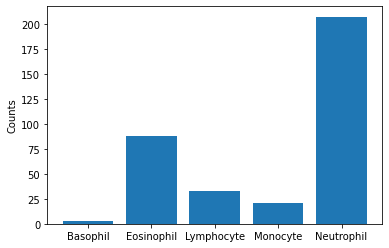

In [6]:
reader = csv.reader(open('data/dataset2-master/dataset2-master/labels.csv'))
# skip the header
next(reader)
X3 = []
y3 = []
for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        y3.append(label)
y3 = np.asarray(y3)
encoder = LabelEncoder()
encoder.fit(y3)
encoded_y = encoder.transform(y3)
counts = np.bincount(encoded_y)
print(counts)
fig, ax = plt.subplots()
plt.bar(list(range(5)), counts)
ax.set_xticklabels(('', 'Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil'))
ax.set_ylabel('Counts')

## Augmented data (rotated, zoom-in + zoom-out, random crop, etc.) to make it balanced

In [7]:
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
#                     img_file = Image.fromarray(img_file).resize(size=(60,80,3))
#                     img_file = resize(img_file, (60,80,3)) #reduce the size of the picture
                    img_file = resize(img_file, (120,160,3)) #reduce the size of the picture
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z

X_train, y_train, z_train = get_data('data/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('data/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
print(dict_characters)
print(dict_characters2)

100%|████████████████████████████████████████████████████████████████████████████████| 624/624 [00:22<00:00, 27.32it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


C:\Users\parshinshojaee\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}


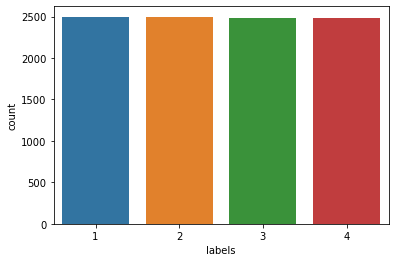

In [8]:
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [9]:
# # Covert Augmented Data to Torch
# X_train_torch = torch.from_numpy(X_train)
# X_train_torch = X_train_torch.reshape((X_train_torch.shape[0], 3,X_train_torch.shape[1],X_train_torch.shape[2]))
# y_train_torch = torch.from_numpy(y_train-1)
# z_train_torch = torch.from_numpy(z_train)

# X_test_torch = torch.from_numpy(X_test)
# X_test_torch = X_test_torch.reshape((X_test_torch.shape[0],3,X_test_torch.shape[1],X_test_torch.shape[2]))
# y_test_torch = torch.from_numpy(y_test-1)
# z_test_torch = torch.from_numpy(z_test)

# trainset_y = TensorDataset(X_train_torch, y_train_torch)
# trainset_z = TensorDataset(X_train_torch, z_train_torch)
# testset_y = TensorDataset(X_test_torch, y_test_torch)
# testset_z = TensorDataset(X_test_torch, z_test_torch)

# #Torch Data Loader:
# train_minibatch_size = 64
# test_minibatch_size = 128
# train_loader = DataLoader(trainset_y, batch_size = train_minibatch_size, shuffle = True)
# test_loader = DataLoader(testset_y, batch_size = test_minibatch_size, shuffle = True)

In [9]:
class BloodDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.images[idx]), self.labels[idx]
        return self.images[idx], self.labels[idx]

In [10]:
tfms = transforms.Compose([transforms.ToTensor()])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#normalize the input data
mean = tuple((X_train.mean(axis=(0,1,2))/255).round(4))
std = tuple((X_train.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize(mean, std)])
train = BloodDataset(X_train, y_train-1, transform=tfms)
#####################################
tfms = transforms.Compose([transforms.ToTensor()])
test = BloodDataset(X_test, y_test-1, transform=tfms)
mean = tuple((X_test.std(axis=(0,1,2))/255).round(4))
std = tuple((X_test.std(axis=(0,1,2))/255).round(4))
tfms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean, std)])
test = BloodDataset(X_test, y_test-1, transform=tfms)
##################################
batch_size = 128
test_size = 128
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=test_size, shuffle=True)

# Task2 : Classification of different cell types

In [24]:
#Train Function:
def train(epoch, model, train_loader):
    model.train()
    
    train_nb_batch = len(train_loader)
    train_loss = 0.0
    train_batch_loss = 0.0
    train_total_loss = 0.0
    train_acc = 0.0
    train_batch_acc = 0.0
    train_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(train_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        #zero that gradients buffer
        optimizer.zero_grad()
        #forward + backward + optimize
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_total_loss += train_batch_loss
        pred_batch_train = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_train = pred_batch_train
        if i >0:
            pred_train = torch.cat([pred_train, pred_batch_train], dim=0)
        train_batch_acc = accuracy_score(pred_batch_train,minibatch_y)
        train_total_acc += train_batch_acc
        
    train_loss = train_total_loss/train_nb_batch
    train_acc = train_total_acc/train_nb_batch
#     scheduler.step()
    return pred_train, train_loss, train_acc

In [25]:
def test(epoch, model, test_loader):
    model.eval()
    
    test_nb_batch = len(test_loader)
    test_loss = 0.0
    test_batch_loss = 0.0
    test_total_loss = 0.0
    test_acc = 0.0
    test_batch_acc = 0.0
    test_total_acc = 0.0
    ####################################
    for i, (minibatch_X, minibatch_y) in enumerate(test_loader):
        minibatch_X = minibatch_X.float().to(device)
        minibatch_y = minibatch_y.long().to(device)
        outputs = model(minibatch_X)
        loss = criterion(outputs, minibatch_y)
        test_batch_loss = loss.item()
        test_total_loss += test_batch_loss
        pred_batch_test = outputs.data.max(1, keepdim=True)[1]
        if i == 0 :
            pred_test = pred_batch_test
        if i >0:
            pred_test = torch.cat([pred_test, pred_batch_test], dim=0)
        test_batch_acc = accuracy_score(pred_batch_test,minibatch_y)
        test_total_acc += test_batch_acc
    test_loss = test_total_loss/test_nb_batch
    test_acc = test_total_acc/test_nb_batch
    return pred_test, test_loss, test_acc

### DenseNet121:

In [26]:
n_classes = 4
densenet121 = models.densenet121(pretrained=True)
for param in densenet121.features.parameters():
    param.requires_grad = False
num_ftrs = densenet121.classifier.in_features
densenet121.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_ftrs, 4) ) 
#                 nn.ReLU(), 
#                 nn.Dropout(0.3),
#                 nn.Linear(8, 4) )
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(densenet121.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, amsgrad=False)
lr = 0.01
optimizer = optim.Adam(densenet121.parameters(), lr=lr)
# scheduler = MultiStepLR(optimizer, milestones=[5,10,20,30,40,60,80], gamma=0.5)

In [ ]:
num_epoch = 100
train_losses = []
test_losses = []
train_accs = []
test_accs= []

for epoch in range(num_epoch):
    pred_train, train_loss, train_acc = train(epoch, densenet121, train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    pred_test, test_loss, test_acc = test(epoch, densenet121, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print("epoch:",epoch,"train loss:", train_loss, "train accuracy:", train_acc)
    print("epoch:",epoch,"test loss:", test_loss, "test accuracy:", test_acc)

epoch: 0 train loss: 1.2119774230015583 train accuracy: 0.5397140375095202
epoch: 0 test loss: 1.0789889574050904 test accuracy: 0.5745383522727272
epoch: 1 train loss: 1.054667659294911 train accuracy: 0.5925252681518152
epoch: 1 test loss: 1.0595445662736893 test accuracy: 0.5909375
epoch: 2 train loss: 1.0785854733907259 train accuracy: 0.59851504982229
epoch: 2 test loss: 1.2453665852546691 test accuracy: 0.5130894886363636
epoch: 3 train loss: 1.0978076587884853 train accuracy: 0.599836966869764
epoch: 3 test loss: 1.0880540907382965 test accuracy: 0.5621732954545455
epoch: 4 train loss: 1.1132082037436657 train accuracy: 0.6023479150799695
epoch: 4 test loss: 1.2041100144386292 test accuracy: 0.5303977272727273
epoch: 5 train loss: 1.039295603067447 train accuracy: 0.6152418126428028
epoch: 5 test loss: 1.061614176630974 test accuracy: 0.5757102272727272
epoch: 6 train loss: 1.1529532334743402 train accuracy: 0.5965584539223153
epoch: 6 test loss: 1.1731312721967697 test accuracy

In [21]:
print('Finished Training')
PATH = './Project_Task2_DenseNet121_100epoch_lr0001_dropout.pkl'
torch.save(densenet121, PATH)

Finished Training


In [22]:
np.save('train_losses_DenseNet121_100epoch_dropout.npy', train_losses)
np.save('train_errors_DenseNet121_100epoch_dropout.npy', train_errors)
np.save('test_losses_DenseNet121_100epoch_dropout.npy', test_losses)
np.save('test_errors_DenseNet121_100epoch_dropout.npy', test_errors)

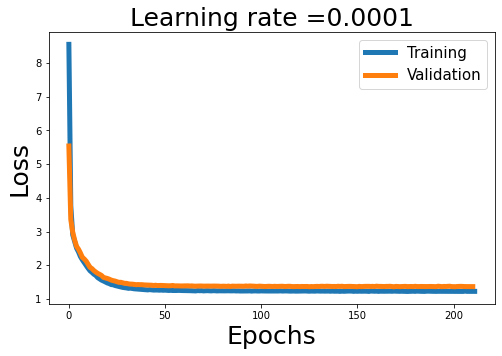

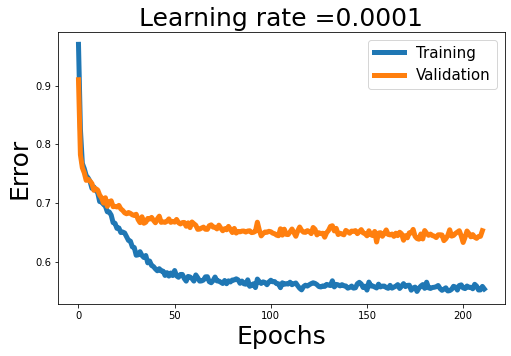

In [19]:
#Plot Train and Validation Loss 
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_losses[:])),train_losses[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_losses[:])),test_losses[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Loss',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_DenseNet121_loss.png')
plt.show() 

#Plot Train and Validation Errors
figure = plt.figure(figsize = [8, 5])
plt.plot(np.arange(len(train_errors[:])),train_errors[:], label='Training', linewidth=5)
plt.plot(np.arange(len(test_errors[:])),test_errors[:], label='Validation', linewidth=5)
plt.legend(fontsize=15)
plt.ylabel('Error',fontsize=25)
plt.xlabel('Epochs',fontsize=25)
plt.title("Learning rate =" + str(0.0001),fontsize=25)
plt.savefig('./Task2_DenseNet121_error.png')
plt.show() 